
### Part 3: Data Preprocessing and Predictive Analysis 

In [213]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from datetime import datetime
from datetime import date
from dateutil import relativedelta
import sklearn

After getting more features from Named Entity Recognition, the table is used to extract further features before training a linear regression model for predictive analysis.

In [214]:
df = pd.read_csv('../en_books_df')

## Preprocessing

In [215]:
def to_seconds(timestr):
    seconds= 0
    for part in timestr.split(':'):
        seconds= seconds*60 + int(part, 10)
    return seconds

In [216]:
## converting runtime to seconds
df['Seconds']= df['Runtime'].apply(to_seconds)

In [217]:
## adding Year columns
df['Year'] = df['Date_uploaded'].str.rsplit(', ', n=1, expand = True)[1]

In [218]:
## dummy column for narrated by
Narrated = pd.get_dummies(df['Narrated_by'] == 'LibriVox Volunteers')

In [219]:
df['Narrated_d'] = Narrated[True]

In [220]:
df.columns

Index(['Title', 'Author', 'Views', 'Favorites', 'Date_uploaded', 'Reviews',
       'Reviews_n', 'Transcripts', 'Genre', 'Language', 'Runtime',
       'Narrated_by', 'NORP', 'PERSON', 'GPE', 'LOC', 'countries_n',
       'states_n', 'all_countries_n', 'US_d', 'male_n', 'female_n',
       'neutral_n', 'Seconds', 'Year', 'Narrated_d'],
      dtype='object')

In [221]:
## drop extra colummns 

In [222]:
df1 = df.drop(['Title','Author', 'Reviews', 'Transcripts', 'NORP', 'PERSON', 'GPE', 'LOC', 'Genre', 'Language', 'Runtime', 'Narrated_by'], axis = 1)

In [223]:
## named entity columns- NORP, PERSON, GPE, LOC
## change column cells from string to list type
## find length of list

In [224]:
import ast
from ast import literal_eval

In [225]:
### extracting the list inside the string
df1['NORP'] = df['NORP'].apply(lambda x: literal_eval(str(x)))

In [226]:
df1['PERSON'] = df['PERSON'].apply(lambda x: literal_eval(str(x)))

In [227]:
df1['GPE'] = df['GPE'].apply(lambda x: literal_eval(str(x)))

In [228]:
df1['LOC'] = df['LOC'].apply(lambda x: literal_eval(str(x)))

In [229]:
### length of each list
df1['NORP_n'] = df1['NORP'].str.len()
df1['PERSON_n'] = df1['PERSON'].str.len()
df1['GPE_n'] = df1['GPE'].str.len()
df1['LOC_n'] = df1['LOC'].str.len()

Note: Calculating months since the book was uploaded.

In [230]:
def getMonthsSinceUpload(d):
    
    start_date = datetime.strptime(d, '%B %d, %Y')
    today = date.today()
    d2 = today.strftime('%d-%m-%Y')
    end_date = datetime.strptime(d2, "%d-%m-%Y")
    delta = relativedelta.relativedelta(end_date, start_date)
    res_months = delta.months + (delta.years * 12)
    
    return res_months

In [231]:
df1['Months_since_upload'] = df1['Date_uploaded'].apply(getMonthsSinceUpload)

Note: Scaling down the Target variable from 'Views' to 'Views_per_month'. This is based on the assumption that the views are evenly distributed over the months since the book was uploaded.

In [232]:
df1['Views_per_month'] = (df1['Views']/df1['Months_since_upload'].where(df1['Months_since_upload'] != 0, 1)).astype(int)

In [233]:
df1['Favorites'].isnull().sum()
#df1.isnull().sum().sum()

25

In [234]:
df1['Favorites'] = df1['Favorites'].fillna(0)

In [235]:
df1

,Views,Favorites,Date_uploaded,Reviews_n,countries_n,states_n,all_countries_n,US_d,male_n,female_n,...,NORP,PERSON,GPE,LOC,NORP_n,PERSON_n,GPE_n,LOC_n,Months_since_upload,Views_per_month
0,155927,102.0,"December 9, 2018",1,2,1,3,0,4,0,...,"[Hebrew, Jewish, Greek, Christian, post-Macabi...","[Canon Charles, John Herkiness, Jubilee, Moon,...","[Erimich, c.p, Jordan, Palestine, Galilee, Isr...","[Northern Palestine, the Accursed Valley, Enak...",16,30,15,5,48,3248
1,302755,58.0,"January 2, 2018",1,1,0,1,0,0,0,...,[Platonist],"[Alexander the Gremarian, Maximus, Tuskeulum, ...","[Relious, Epilonia, Greece, Marcus]",[],1,8,4,0,59,5131
2,516824,7.0,"July 1, 2018",0,0,0,0,0,0,0,...,[],[],[],[],0,0,0,0,53,9751
3,402442,4.0,"March 2, 2018",0,0,4,1,0,1,0,...,"[Greek, Latin]","[William Morris Davis, John Wesley Powell, Cri...","[Ohio, Malaska, Illinois, the United States, J...","[the Genesee Valley, Mississippi]",2,8,11,2,57,7060
4,364346,17.0,"August 16, 2018",0,0,2,1,0,4,2,...,"[Dutch, American]","[P. Body, Gang, forgeri, Prentice Parker Singl...","[St. Louis, West 38th Street, St. Paul, New Yo...",[the Bay window],2,41,6,1,52,7006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,10073,1.0,"November 9, 2022",0,0,0,0,0,1,2,...,[],"[Rose Chickenhouse, Hurry, Laura, Tom Wildcat,...",[],[],0,7,0,0,1,10073
237,56821,2.0,"April 30, 2022",0,0,0,0,0,6,1,...,[English],"[Ferdinand DeVero, Count Adelaan, Samuel Pickw...","[Gowland, Librevox, Persona, Veyola]",[],1,8,4,0,7,8117
238,29381,1.0,"November 4, 2022",1,2,1,3,0,7,1,...,"[Greek, American, Zedafans, Persians, American...","[Alexander W. Donafin, Saldo, Cook, Wayne Cook...","[El Paso, Tigris, Zedafans, Mexico, Monterey, ...","[the Gulf of Mexico, the Pacific Ocean, Missis...",9,12,15,4,1,29381
239,32539,2.0,"November 10, 2022",0,0,0,0,0,5,1,...,[French],"[Jip Seeds, Buster, Fritz, Jip Seed, Francis T...",[Puppets],[Europe],1,7,1,1,1,32539


## Predictive Modeling with Linear Regression Model

In [236]:
X1 = df1.drop(['Views', 'Views_per_month', 'Year', 'NORP','LOC', 'PERSON','GPE', 'Date_uploaded'], axis=1)
y = df1['Views_per_month']

In [237]:
X1.head(20)

,Favorites,Reviews_n,countries_n,states_n,all_countries_n,US_d,male_n,female_n,neutral_n,Seconds,Narrated_d,NORP_n,PERSON_n,GPE_n,LOC_n,Months_since_upload
0,102.0,1,2,1,3,0,4,0,3,16136,0,16,30,15,5,48
1,58.0,1,1,0,1,0,0,0,0,17266,1,1,8,4,0,59
2,7.0,0,0,0,0,0,0,0,0,779,1,0,0,0,0,53
3,4.0,0,0,4,1,0,1,0,0,13251,0,2,8,11,2,57
4,17.0,0,0,2,1,0,4,2,1,24590,0,2,41,6,1,52
5,1.0,0,0,0,0,0,1,0,1,4641,1,0,1,3,1,56
6,6.0,3,0,3,2,0,2,1,0,26532,0,0,28,9,0,56
7,3.0,0,2,0,2,0,0,1,0,18835,1,2,7,5,0,51
8,37.0,1,1,1,3,0,2,0,0,59362,1,13,33,21,1,52
9,0.0,0,0,2,3,0,6,0,0,23367,0,2,35,17,0,56


#### Checking multicolinearity between columns - it shows that all_countries_n and GPE_n have high multicolinearity, and hence have been excluded from our features table.

In [255]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X1.columns
vif_data["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(len(X1.columns))]

/Users/kamathshashwath/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [256]:
vif_data

,feature,VIF
0,Favorites,1.538986
1,Reviews_n,1.232909
2,countries_n,7.157695
3,states_n,5.403002
4,all_countries_n,12.579472
5,US_d,NaN
6,male_n,5.869370
7,female_n,3.040766
8,neutral_n,1.545682
9,Seconds,2.184642


In [240]:
X = X1.drop(['all_countries_n', 'GPE_n'], axis = 1)

In [241]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)

In [242]:
## Linear Regression Model
from sklearn.linear_model import LinearRegression

In [243]:
lin_reg = LinearRegression()

In [244]:
lin_reg.fit(X_train,y_train)

LinearRegression()

In [245]:
pred = lin_reg.predict(X_test)

In [246]:
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': pred.squeeze()})

In [247]:
df_preds.head(5)

,Actual,Predicted
180,5240,10557.738414
162,3299,10707.535437
119,5200,10451.283558
187,64048,18907.304785
46,2038,-2168.465845


In [248]:
lin_reg .score(X_train, y_train)

0.41561279660755335

In [249]:
# accuracy score
lin_reg .score(X_test, y_test)

0.2620377569337553

In [250]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 6769.43849013041
Mean Squared Error: 98522596.71310166
Root Mean Squared Error: 9925.854961317018


#### Note: Higher rmse means there is still a lot of noise in the data. This could mean that the textual data requires further preprocessing. Another reason could be the inaccuracy of Whisper's speech-to-text conversion. 

In [251]:
## fit of the model
r2_sk = metrics.r2_score(y_test,pred)
N= y_test.shape[0]
p=3
x = (1-r2_sk)
y = (N-1) / (N-p-1)
adj_rsquared = (1 - (x * y))
print("Adjusted-R2 : " , adj_rsquared)

Adjusted-R2 :  0.21284027406267236


/Users/kamathshashwath/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Views_per_month'>

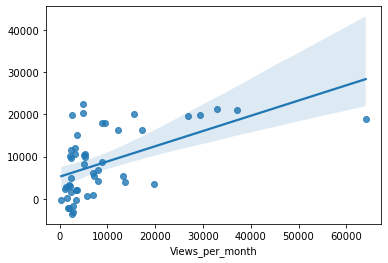

In [252]:
sns.regplot(y_test, pred)

#### Conclusion: Considering the negative values in the prediction, the low adjusted R2 and high RMSE, the model needs more features for improved features.